In [1]:
# Make sure the runtime is on GPU
# Download the common libraries
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
# Download the subset dataset
#!git clone https://github.com/parth1620/Person-Re-Id-Dataset

'git' is not recognized as an internal or external command,
operable program or batch file.


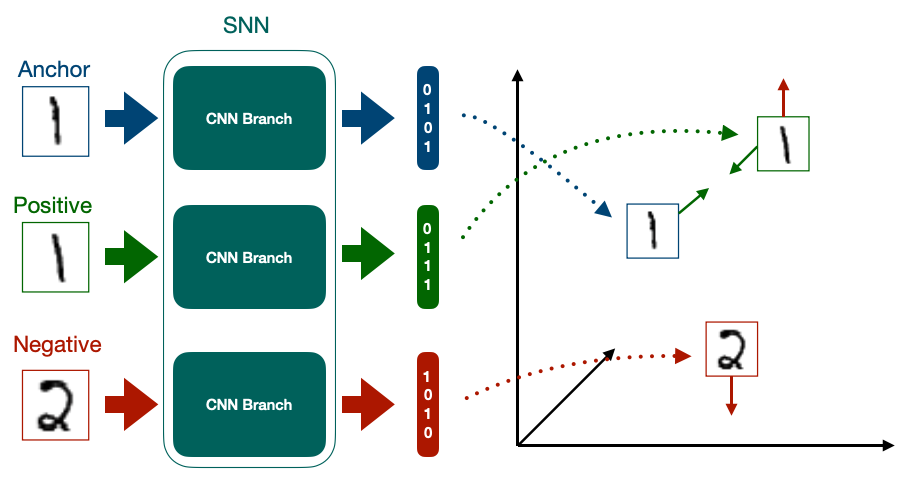

# Imports

In [3]:
# import sys
# sys.path.append('/content/Person-Re-Id-Dataset')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import os

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations配置

In [39]:
# `train` file contains the images
# `utils.py` file contains the visualization functions

# Definition
DATA_DIR = 'E:\\slu810\\extracted_images_all\\'
CSV_FILE = 'E:\slu810\extracted_images_all.csv'

BATCH_SIZE = 16
LR = 0.001 # Learning read
EPOCHS = 150

DEVICE = 'cuda' # We are on the GPU device

In [40]:
# Read the `extracted_images.csv` file
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Positive,Negative
0,0_1198_22-10-20_C2_06.jpg,0_2995_22-10-20_C2_06.jpg,2_7787_22-10-20_C2_06.jpg
1,0_1198_22-10-20_C2_06.jpg,0_3594_22-10-20_C2_06.jpg,5_599_22-10-20_C2_06.jpg
2,0_1198_22-10-20_C2_06.jpg,0_4193_22-10-20_C2_06.jpg,1_8386_22-10-20_C2_06.jpg
3,0_1198_22-10-20_C2_06.jpg,0_4792_22-10-20_C2_06.jpg,7_16772_22-10-20_C2_06.jpg
4,0_1198_22-10-20_C2_06.jpg,0_5391_22-10-20_C2_06.jpg,12_9584_22-10-20_C2_06.jpg


In [41]:
# Read the images
row = df.iloc[4] # read the example number 4

A_img = io.imread(os.path.join(DATA_DIR + row.Anchor))
P_img = io.imread(os.path.join(DATA_DIR + row.Positive))
N_img = io.imread(os.path.join(DATA_DIR + row.Negative))

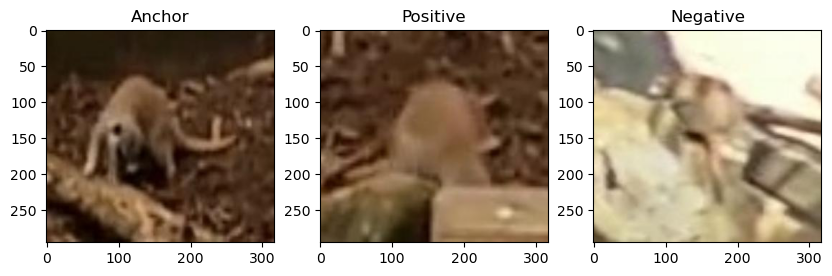

In [42]:
# Plot the images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5)) # plot a subplot

ax1.set_title("Anchor")
ax1.imshow(A_img) # Plot the Anchor image

ax2.set_title("Positive")
ax2.imshow(P_img) # Plot the Positive image

ax3.set_title("Negative")
ax3.imshow(N_img) # Plot the Negative image

In [44]:
# Split dataset into training and validation
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42) # test size is 20%

# Create APN Dataset -- a custom dataset

In [45]:
# Define a class which has three methods
class APN_Dataset(Dataset): # inherite from class `Dataset`

  def __init__(self, df): # init method - pass our dataframe
    self.df = df

  def __len__(self): # length method - return the size of the dataset
    return len(self.df)

  def __getitem__ (self, idx): #get item method - return the anchor positive and negative image according to the given

    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)


    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

获取项目方法:

def __getitem__(self, idx): 定义了如何根据索引 idx 获取数据。这使得你可以像这样访问数据集的项目：dataset[idx]。

row = self.df.iloc[idx] 从 dataframe 中获取第 idx 行的数据。

接下来，使用 io.imread 函数从 DATA_DIR 加载与该行相关的三个图像（Anchor, Positive, Negative）。

图像数据从形状 (Height, Width, Channels) 转化为 (Channels, Height, Width)，这是 PyTorch 中常见的格式。此外，图像数据被归一化，除以 255，将像素值从 [0, 255] 转化为 [0, 1]。

return A_img, P_img, N_img 返回这三个处理后的图像。

在这样的任务中，模型的目标是确保锚点图像与正图像更相似，而与负图像更不相似。

In [46]:
# Creating instance
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

# Print the size of dataset
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 85668
Size of validset : 21418


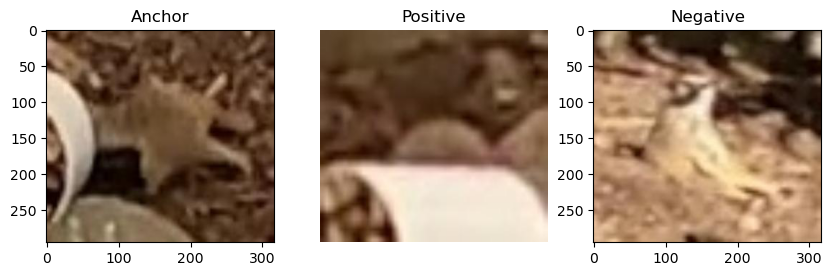

In [47]:
# Plot the images
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.axis('off')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [48]:
# Create train loader and valid loader
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

以上代码的目的是使用PyTorch中的DataLoader类，为训练集和验证集创建数据加载器。数据加载器可迭代，允许批量、乱序和并行加载数据。

创建数据加载器:

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True):

- trainset 是我们要加载的数据集。

- batch_size = BATCH_SIZE 表示每个批次要加载的数据项数量。这里使用了一个名为 BATCH_SIZE 的变量，这个变量需要在其他地方被定义并赋值。

- shuffle = True 表示在每个训练时代开始之前，都将对数据进行乱序处理。这对于训练通常是有用的，因为它可以帮助模型更好地泛化，并避免某些固定的数据排序引起的问题。

validloader = DataLoader(validset, batch_size = BATCH_SIZE):

- 这是为验证集创建的加载器。
- 通常，验证过程不需要数据乱序，因此这里没有指定shuffle参数（默认为False）。

In [49]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 5355
No. of batches in validloader : 1339


In [50]:
# Print one image shape from the data loader
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([16, 3, 295, 317])


# Create Model

In [51]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings

In [52]:
model = APN_Model()
model.to(DEVICE);

# Create Train and Eval function

In [53]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [54]:
def eval_fn(model, dataloader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():

    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)


      total_loss += loss.item()

    return total_loss / len(dataloader)

In [55]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [72]:
# # 1. 初始化一个DataFrame来存储损失数据
# loss_df = pd.DataFrame(columns=['epoch', 'train_loss', 'valid_loss'])

# best_valid_loss = np.Inf


# for i in range(EPOCHS):

#   train_loss = train_fn(model, trainloader, optimizer, criterion)
#   valid_loss = eval_fn(model, validloader, criterion)

#   # 2. 在每个epoch的结束，将新的数据添加到DataFrame
#   new_row = {'epoch': i+1, 'train_loss': train_loss, 'valid_loss': valid_loss}
#   loss_df = loss_df.append(new_row, ignore_index=True)

#   if valid_loss < best_valid_loss:
#     torch.save(model.state_dict(), 'best_model.pt')
#     best_valid_loss = valid_loss
#     print("SAVED_WEIGHTS_SUCCESS")

#   print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")


# # 3. 将数据保存到CSV文件
# loss_df.to_csv('training_loss_data.csv', index=False)

# # 4. 绘制损失曲线图
# plt.figure(figsize=(12, 6))
# plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss')
# plt.plot(loss_df['epoch'], loss_df['valid_loss'], label='Valid Loss', linestyle='--')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()
# plt.show()

In [56]:
import csv

# 创建一个CSV文件，并初始化列名
with open("losses.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train_Loss", "Valid_Loss"])

best_valid_loss = np.Inf

# 创建两个列表，用于存储每个时期的train_loss和valid_loss
train_losses = []
valid_losses = []

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)
    
    # 添加损失到列表中
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # 将损失值写入到CSV文件中
    with open("losses.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, train_loss, valid_loss])

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

# 绘制train_loss和valid_loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Train Loss and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

100%|██████████| 1339/1339 [04:23<00:00,  5.09it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.5396571228449363 valid_loss : 0.8121922598168243


100%|██████████| 1339/1339 [04:21<00:00,  5.12it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.2658100963612787 valid_loss : 0.7835148444052861


100%|██████████| 1339/1339 [04:27<00:00,  5.00it/s]


EPOCHS : 3 train_loss : 0.17249934182447546 valid_loss : 0.8295809260894328


 33%|███▎      | 1784/5355 [13:11<26:23,  2.26it/s]


KeyboardInterrupt: 

# Get Anchor Embeddings

In [22]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [23]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4348/4348 [01:31<00:00, 47.33it/s]


In [24]:
df_enc.to_csv('database.csv', index = False)

# 如果你想根据整个行去除重复项，则无需使用subset参数
df_enc = df_enc.drop_duplicates(keep='first')
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0_1198_22-10-20_C2_06.jpg,-0.690442,-0.247417,0.301809,-0.707249,0.599154,-0.238769,-0.784681,-2.220918,0.189399,...,-0.548922,-0.216308,0.325877,0.244584,-0.610454,-0.156332,-0.171739,-0.174211,1.361353,0.143977
12,0_1797_22-10-20_C2_06.jpg,-0.771410,-0.167479,0.479285,-0.589566,0.887706,-0.379431,-0.923284,-2.618402,0.253886,...,-0.942035,-0.270840,0.372683,-0.071543,-0.732327,-0.088341,-0.231695,-0.258900,1.604247,0.148229
23,0_2396_22-10-20_C2_06.jpg,-0.758337,-0.171572,0.502280,-0.464478,0.792635,-0.513235,-0.757616,-2.517780,0.149341,...,-0.814933,-0.340581,0.347123,0.011331,-0.629760,-0.088465,-0.244722,-0.302331,1.484545,0.083742
34,0_2995_22-10-20_C2_06.jpg,-0.739346,-0.151317,0.464636,-0.498889,0.781190,-0.472896,-0.741484,-2.393994,0.174098,...,-0.748843,-0.324121,0.296693,0.052100,-0.603209,-0.113729,-0.228942,-0.271481,1.410279,0.161576
44,0_3594_22-10-20_C2_06.jpg,-0.727785,-0.146983,0.426310,-0.502474,0.740071,-0.441517,-0.732205,-2.394318,0.135515,...,-0.652889,-0.331367,0.362118,0.108557,-0.588378,-0.159537,-0.199261,-0.223737,1.362071,0.125843


# Inference

In [25]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [26]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [27]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [28]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [29]:
closest_idx = np.argsort(distance)

In [30]:
import networkx as nx
from skimage import io
import matplotlib.pyplot as plt

def plot_closest_imgs(anc_img_names, DATA_DIR, image, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    # Since the DATA_DIR is already in img_path, we don't need to add it again.
    # Also, we're adapting to the new path format (using backslashes)
    S_name = [img_path.split('\\')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i in range(len(S_name)):
        # Since the DATA_DIR is already in img_path, we don't need to add it again.
        image = io.imread(DATA_DIR + S_name[i])

        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j-1]])

    pos = nx.kamada_kawai_layout(G)

    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa-p2, ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')
    ax.axis('off')
    plt.show()


c:\Users\slu810\AppData\Local\anaconda3\envs\extract\Lib\site-packages\networkx\drawing\layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


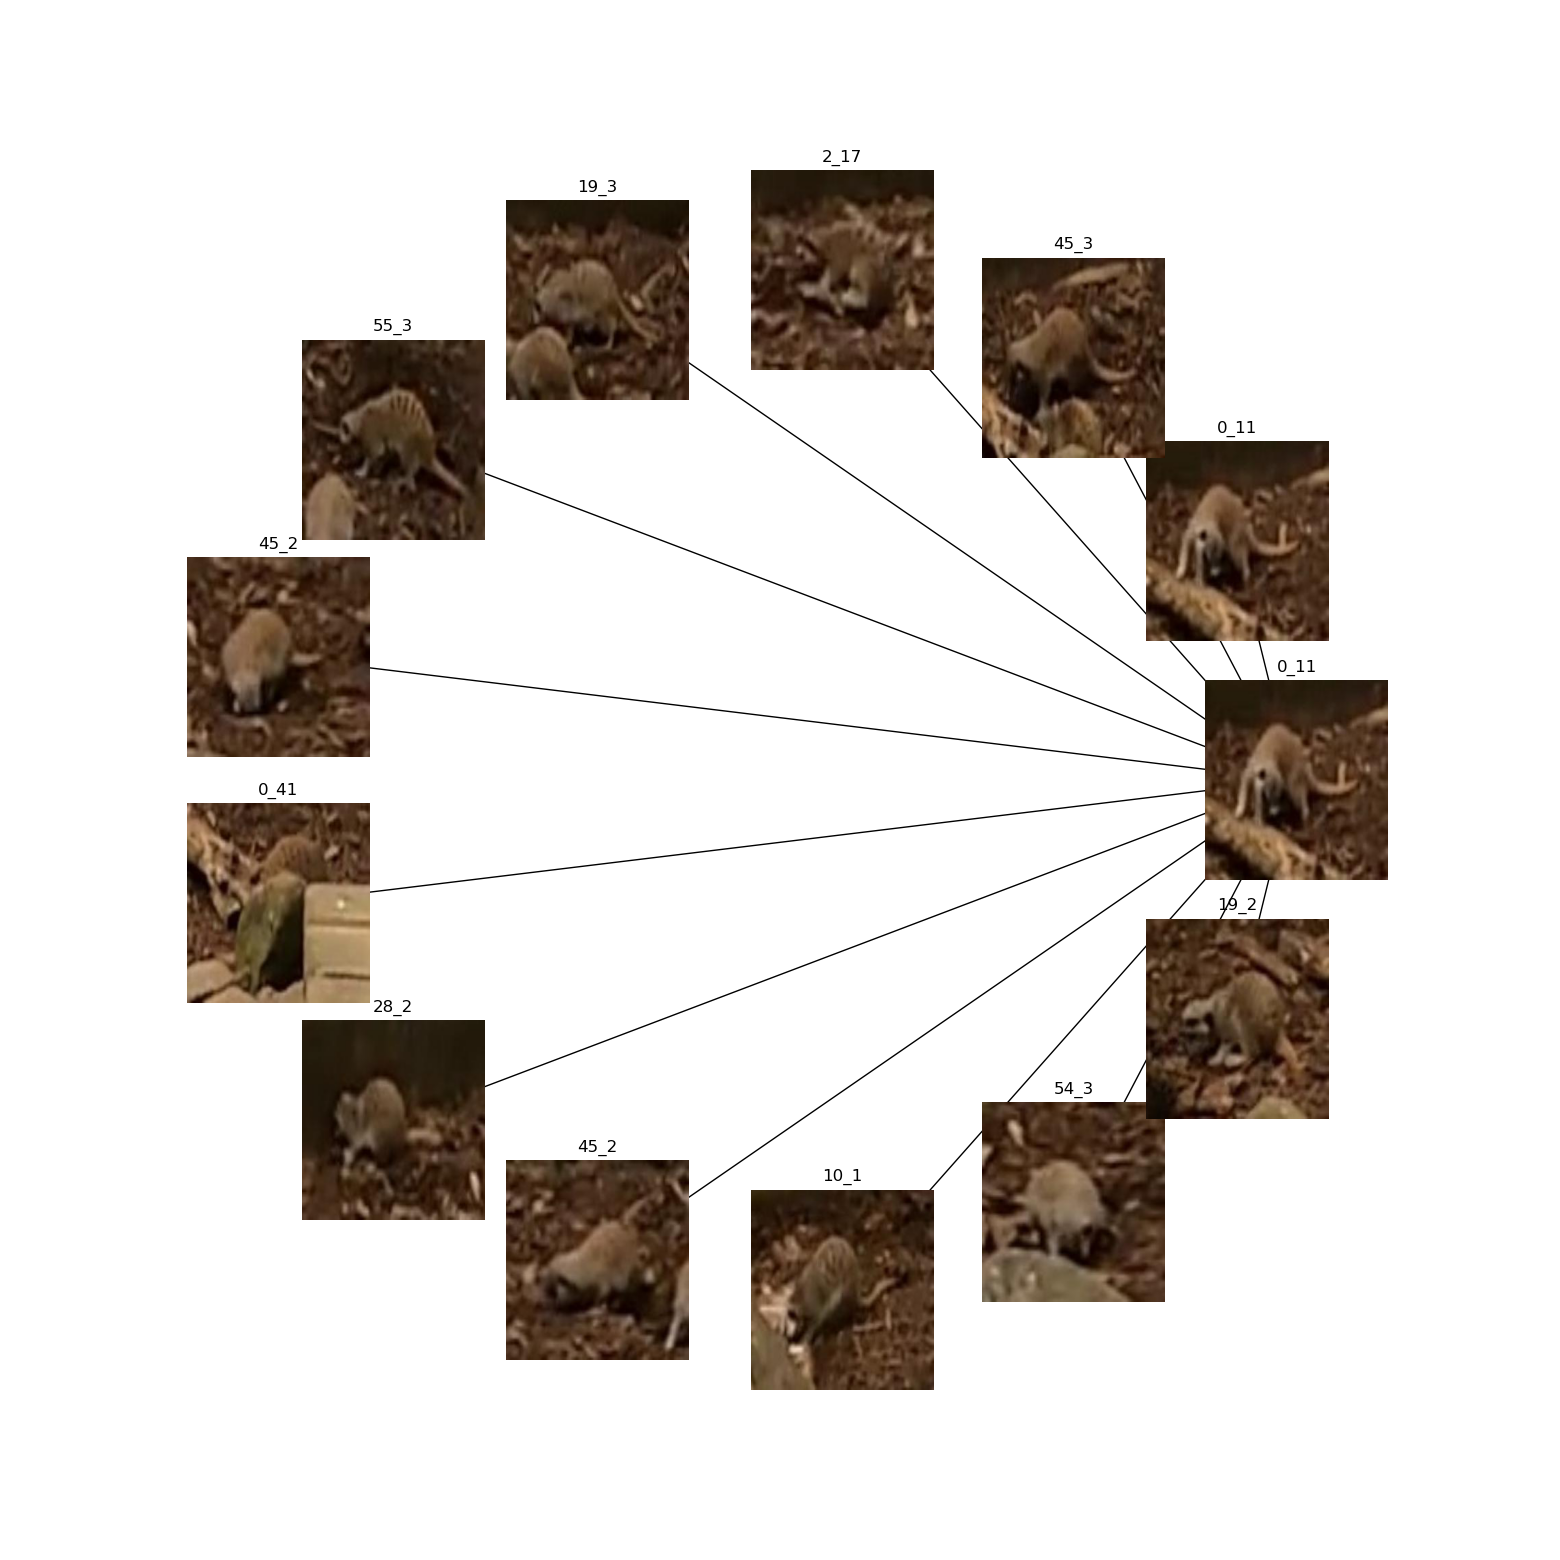

In [31]:
#from utils import plot_closest_imgs


plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 12);